# Exploratory Data Analysis: LLM vs Human Text Classification

This notebook performs comprehensive exploratory data analysis on the LLM vs Human text datasets to understand the characteristics and differences between machine-generated and human-generated texts.

## Dataset Overview
- **combined.csv**: Complete dataset (8.7GB)
- **balanced.csv**: Balanced subset (3.2GB)
- **Labels**: `llm` (machine-generated) vs `human` (human-generated)

## Analysis Goals
1. Basic dataset statistics and distributions
2. Text length and vocabulary analysis
3. Linguistic feature comparison
4. Statistical significance testing
5. Identify key distinguishing characteristics


In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 1.26.4


In [13]:
# Define helper functions for efficient data loading and analysis

def load_data_sample(filename, n_samples=10000, random_state=42):
    """Load a random sample from large CSV files for initial exploration"""
    # First, get the total number of lines
    with open(filename, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for line in f) - 1  # Subtract header
    
    # Calculate skip probability
    skip_prob = 1 - (n_samples / total_lines)
    
    # Load sample
    df = pd.read_csv(filename, 
                     skiprows=lambda x: x > 0 and np.random.random() < skip_prob,
                     encoding='utf-8')
    
    print(f"Loaded {len(df):,} samples from {filename}")
    print(f"Total file size: {total_lines:,} rows")
    return df

def load_data_chunks(filename, chunksize=50000):
    """Generator to load data in chunks for memory-efficient processing"""
    return pd.read_csv(filename, chunksize=chunksize, encoding='utf-8')

def calculate_text_features(text):
    """Calculate various text features for analysis"""
    if pd.isna(text) or not isinstance(text, str):
        return {
            'length': 0, 'word_count': 0, 'sentence_count': 0,
            'avg_word_length': 0, 'punctuation_count': 0
        }
    
    # Basic metrics
    length = len(text)
    words = text.split()
    word_count = len(words)
    sentences = re.split(r'[.!?]+', text)
    sentence_count = len([s for s in sentences if s.strip()])
    
    # Advanced metrics
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    punctuation_count = len(re.findall(r'[.!?,:;()]', text))
    
    return {
        'length': length,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'punctuation_count': punctuation_count
    }

print("Helper functions defined!")


Helper functions defined!


## 1. Initial Data Exploration

Let's start by loading samples from both datasets to understand the structure and basic characteristics.


In [14]:
# Load samples from both datasets
print("Loading samples from datasets...")
print("=" * 50)

# Load combined dataset sample  
combined_sample = load_data_sample('processed_filtered_chunked_batch.csv', n_samples=20000)
print()


print("COMBINED DATASET SAMPLE:")
print(f"Shape: {combined_sample.shape}")
print(f"Columns: {list(combined_sample.columns)}")
print(f"Label distribution:")
print(combined_sample['label'].value_counts())


Loading samples from datasets...
Loaded 737 samples from processed_filtered_chunked_batch.csv
Total file size: 69,190,025 rows

COMBINED DATASET SAMPLE:
Shape: (737, 4)
Columns: ['label', 'text', 'original_length', 'chunk_id']
Label distribution:
label
human    669
llm       68
Name: count, dtype: int64


In [15]:
# Examine sample texts
print("SAMPLE TEXTS:")
print("=" * 50)

print("\nHUMAN TEXT EXAMPLES:")
human_samples = combined_sample[combined_sample['label'] == 'human']['text'].head(3)
for i, text in enumerate(human_samples, 1):
    print(f"\nHuman Example {i}:")
    print("-" * 30)
    print(text[:300] + "..." if len(text) > 300 else text)

print("\n\nLLM TEXT EXAMPLES:")
llm_samples = combined_sample[combined_sample['label'] == 'llm']['text'].head(3)
for i, text in enumerate(llm_samples, 1):
    print(f"\nLLM Example {i}:")
    print("-" * 30)
    print(text[:300] + "..." if len(text) > 300 else text)


SAMPLE TEXTS:

HUMAN TEXT EXAMPLES:

Human Example 1:
------------------------------
['Chamamos de Idade do Ferro o período em que os seres humanos adquiriram conhecimento para extrair e derreter o ferro e utilizá-lo na fabricação de ferramentas, armas e utensílios.'
 'Pertencente à pré-história dos humanos, a Idade do Ferro é um dos momentos que compõe essa época, juntamente com a ...

Human Example 2:
------------------------------
['Com uma apresentação perfeita, o Palmeiras se isolou na liderança do Brasileirão na noite desta quinta-feira, quando goleou o Figueirense pelo placar de 4 a 0, no Allianz Parque, pela 12ª rodada.'
 'A equipe paulista segue com 100% de aproveitamento jogando como mandante no torneio.']
['A vitória ...

Human Example 3:
------------------------------
['e claro, também pelo trabalho com os circulos, que trazem alegria e movimento ao LO.']
['tudo lindo e perfeito!!!']
['E esta página fiz especialmente para o stand da True Colors, na Mega Artesanal, era pra t

## 2. Text Feature Analysis

Now let's calculate various text features to understand the characteristics of LLM vs human texts.


In [16]:
# Calculate text features for balanced sample
print("Calculating text features...")

# Apply feature calculation to the balanced sample
features_list = []
for idx, row in combined_sample.iterrows():
    features = calculate_text_features(row['text'])
    features['label'] = row['label']
    features['index'] = idx
    features_list.append(features)

# Create features dataframe
features_df = pd.DataFrame(features_list)

print(f"Features calculated for {len(features_df)} texts")
print("\nFeature columns:", list(features_df.columns))
print("\nFeatures DataFrame shape:", features_df.shape)


Calculating text features...
Features calculated for 737 texts

Feature columns: ['length', 'word_count', 'sentence_count', 'avg_word_length', 'punctuation_count', 'label', 'index']

Features DataFrame shape: (737, 7)


In [17]:
# Basic statistics by label
print("TEXT FEATURE STATISTICS BY LABEL")
print("=" * 50)

feature_cols = ['length', 'word_count', 'sentence_count', 'avg_word_length', 'punctuation_count']

for feature in feature_cols:
    print(f"\n{feature.upper()}:")
    stats_by_label = features_df.groupby('label')[feature].agg(['count', 'mean', 'std', 'min', 'max'])
    print(stats_by_label.round(2))
    
    # Statistical test
    human_values = features_df[features_df['label'] == 'human'][feature]
    llm_values = features_df[features_df['label'] == 'llm'][feature]
    
    # Mann-Whitney U test (non-parametric)
    statistic, p_value = stats.mannwhitneyu(human_values, llm_values, alternative='two-sided')
    print(f"Mann-Whitney U test p-value: {p_value:.6f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    print("-" * 40)


TEXT FEATURE STATISTICS BY LABEL

LENGTH:
       count     mean      std  min   max
label                                    
human    669  3734.33  3281.28   51  9999
llm       68   546.04   515.78  100  2536
Mann-Whitney U test p-value: 0.000000
Significant difference: Yes
----------------------------------------

WORD_COUNT:
       count    mean     std  min   max
label                                  
human    669  595.90  527.00    8  1798
llm       68   92.66   93.16    3   453
Mann-Whitney U test p-value: 0.000000
Significant difference: Yes
----------------------------------------

SENTENCE_COUNT:
       count   mean    std  min  max
label                               
human    669  31.84  33.01    1  291
llm       68   5.87   5.78    1   31
Mann-Whitney U test p-value: 0.000000
Significant difference: Yes
----------------------------------------

AVG_WORD_LENGTH:
       count  mean    std   min    max
label                                 
human    669  5.27   0.46  3.39   9

## 3. Visualizations

Let's create comprehensive visualizations to compare LLM and human text characteristics.


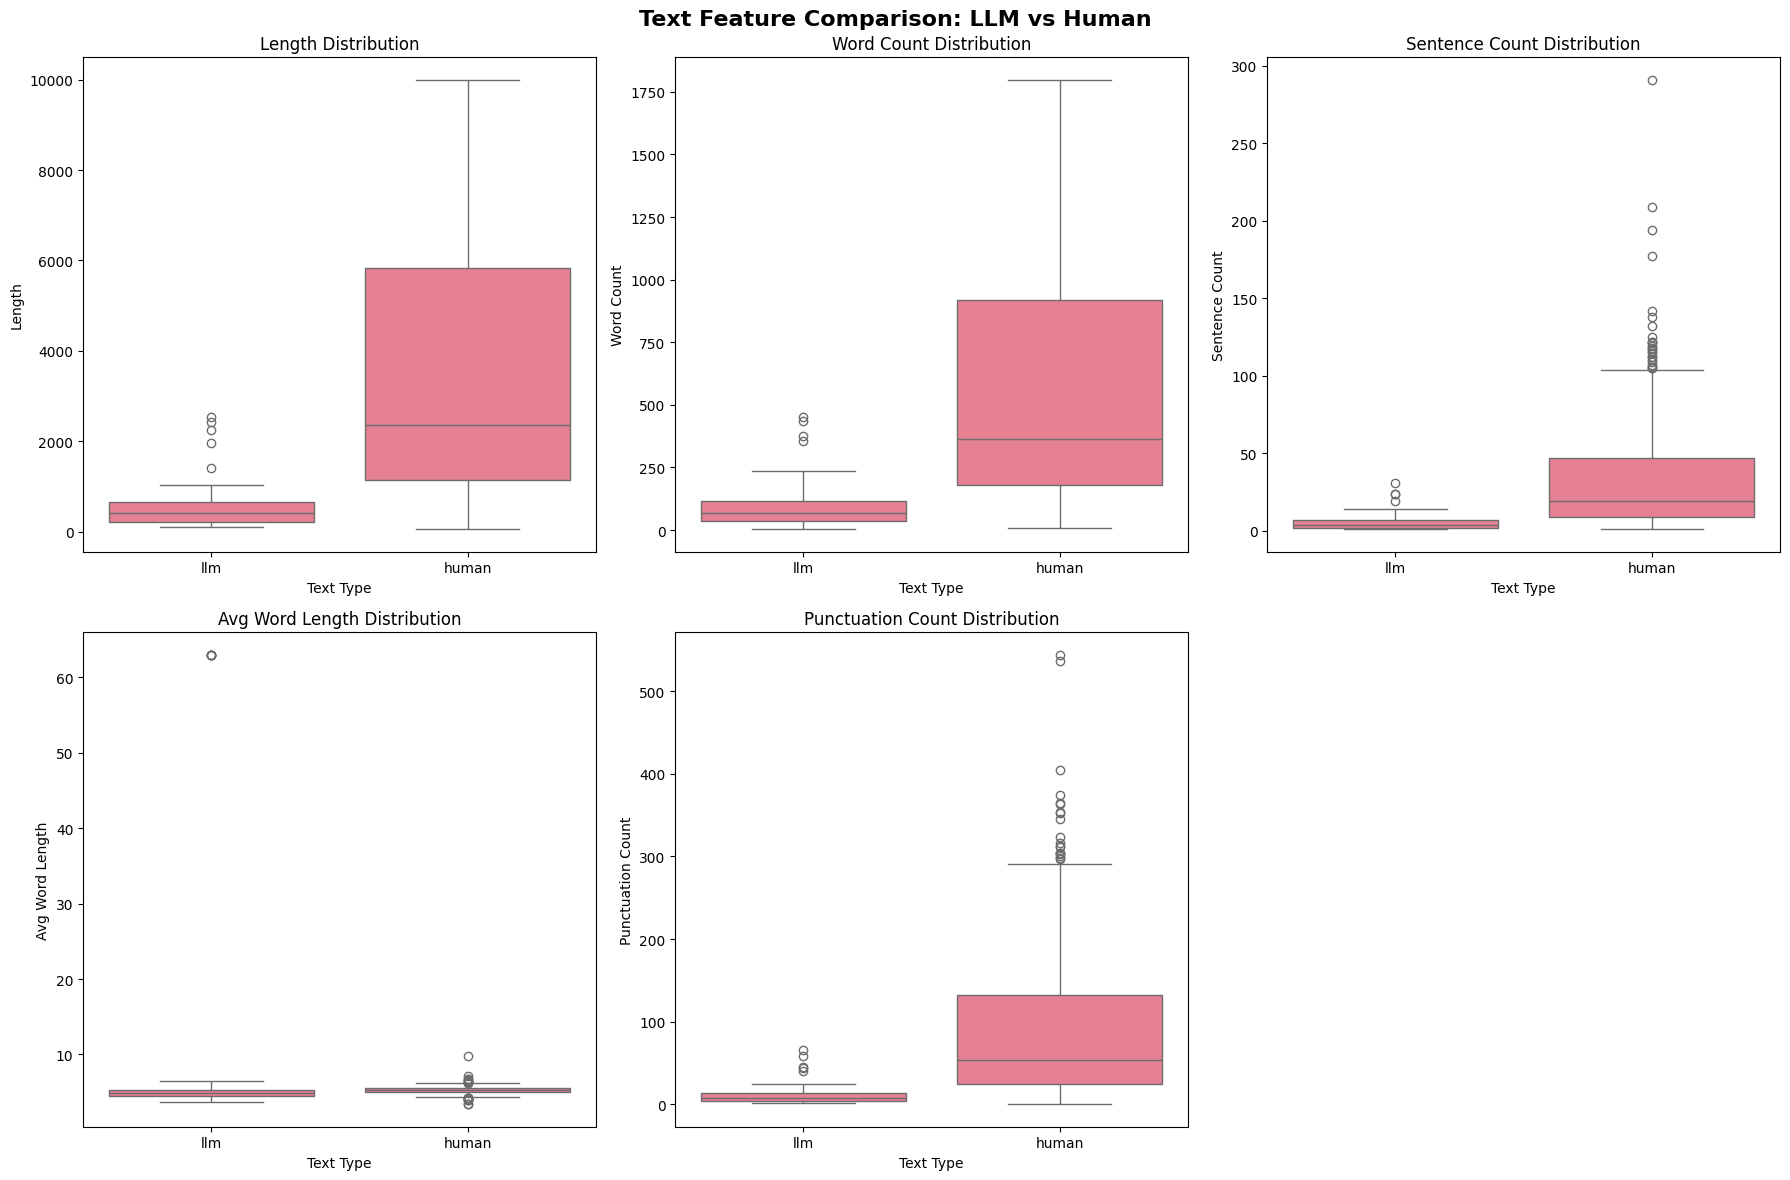

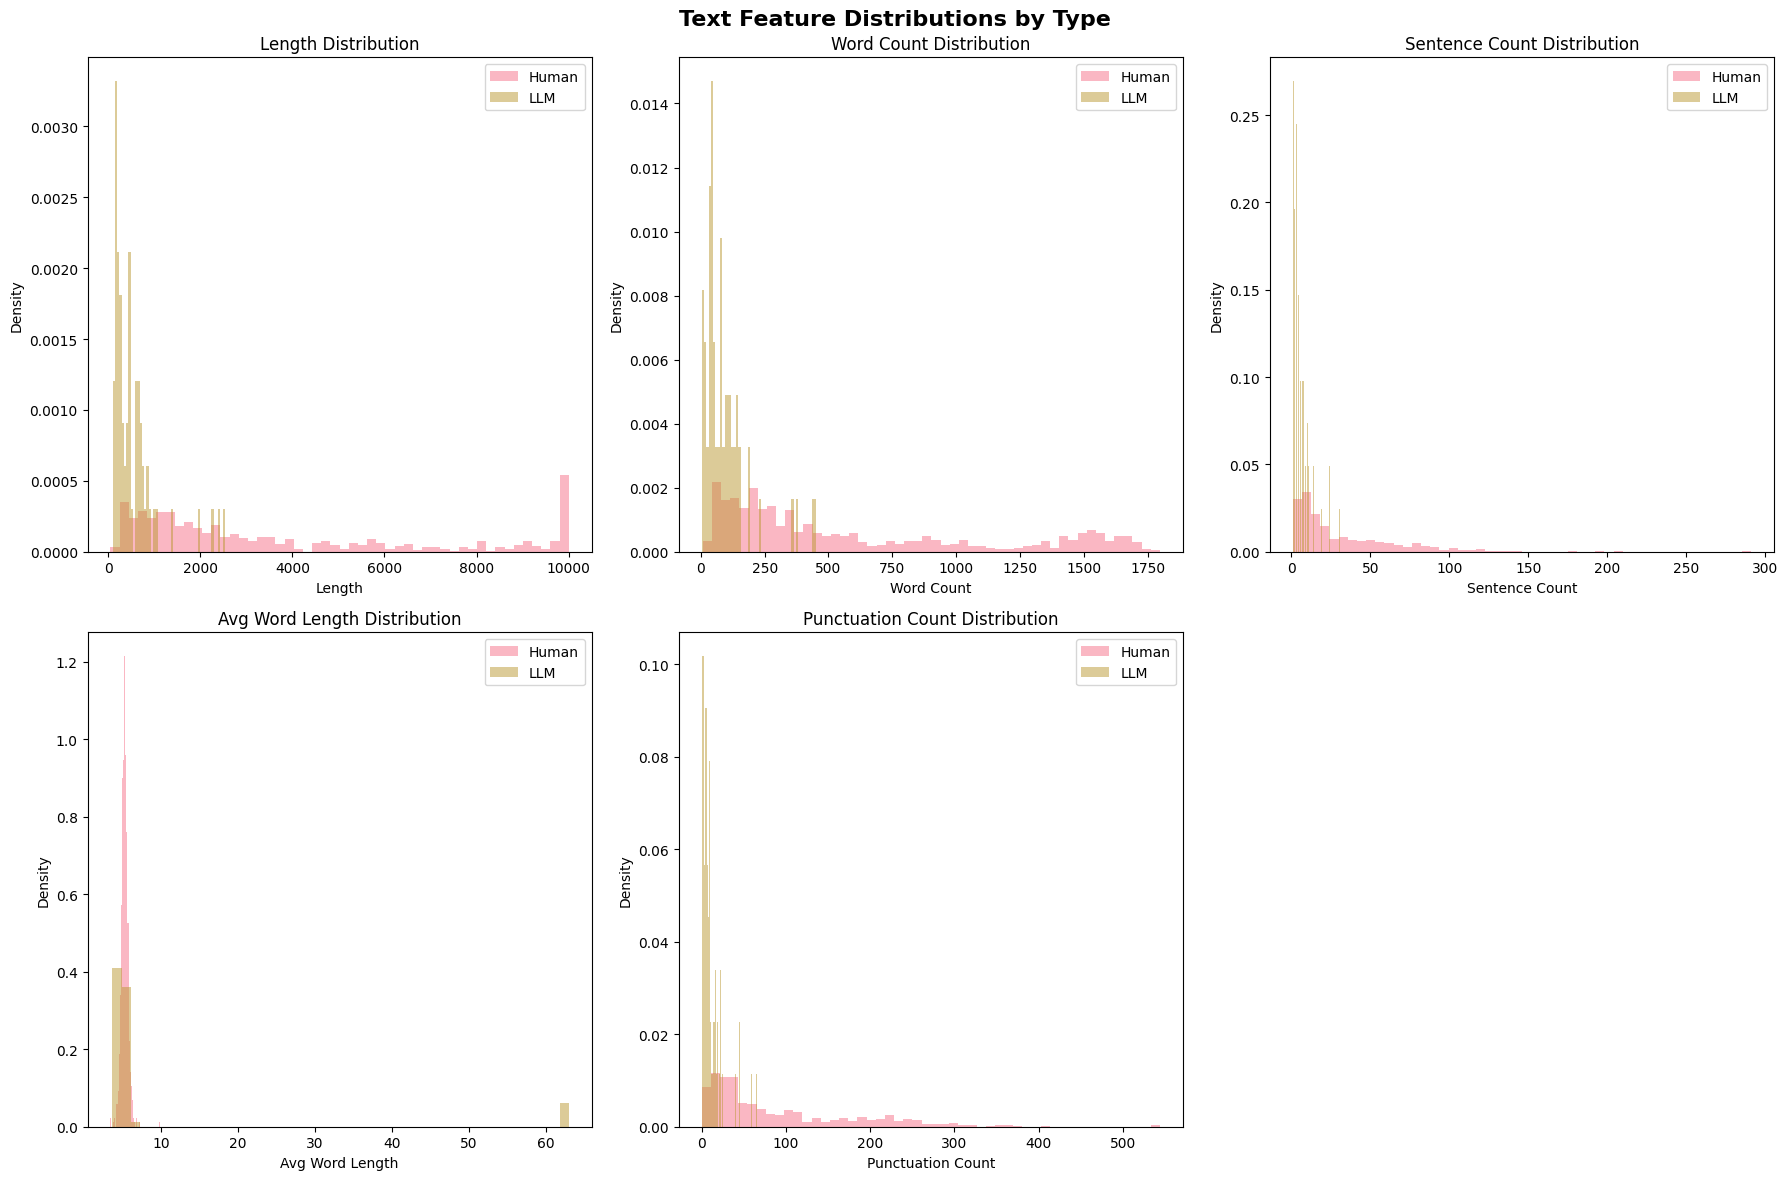

In [18]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Text Feature Comparison: LLM vs Human', fontsize=16, fontweight='bold')

features_to_plot = ['length', 'word_count', 'sentence_count', 'avg_word_length', 'punctuation_count']

# Create box plots and histograms
for i, feature in enumerate(features_to_plot):
    row = i // 3
    col = i % 3
    
    # Box plot
    if row < 2 and col < 3:
        sns.boxplot(data=features_df, x='label', y=feature, ax=axes[row, col])
        axes[row, col].set_title(f'{feature.replace("_", " ").title()} Distribution')
        axes[row, col].set_xlabel('Text Type')
        axes[row, col].set_ylabel(feature.replace("_", " ").title())

# Remove empty subplot
if len(features_to_plot) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# Create distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Text Feature Distributions by Type', fontsize=16, fontweight='bold')

for i, feature in enumerate(features_to_plot):
    row = i // 3
    col = i % 3
    
    if row < 2 and col < 3:
        # Histogram with overlaid densities
        human_data = features_df[features_df['label'] == 'human'][feature]
        llm_data = features_df[features_df['label'] == 'llm'][feature]
        
        axes[row, col].hist(human_data, alpha=0.5, label='Human', bins=50, density=True)
        axes[row, col].hist(llm_data, alpha=0.5, label='LLM', bins=50, density=True)
        axes[row, col].set_title(f'{feature.replace("_", " ").title()} Distribution')
        axes[row, col].set_xlabel(feature.replace("_", " ").title())
        axes[row, col].set_ylabel('Density')
        axes[row, col].legend()

# Remove empty subplot
if len(features_to_plot) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS


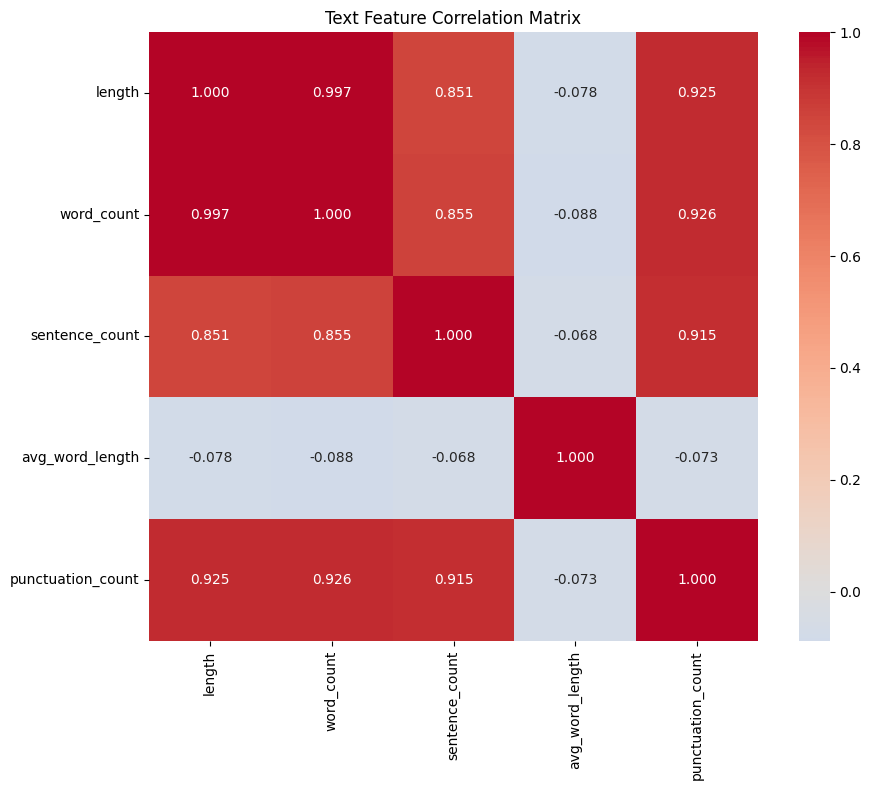

Correlation Matrix:
                   length  word_count  sentence_count  avg_word_length  \
length              1.000       0.997           0.851           -0.078   
word_count          0.997       1.000           0.855           -0.088   
sentence_count      0.851       0.855           1.000           -0.068   
avg_word_length    -0.078      -0.088          -0.068            1.000   
punctuation_count   0.925       0.926           0.915           -0.073   

                   punctuation_count  
length                         0.925  
word_count                     0.926  
sentence_count                 0.915  
avg_word_length               -0.073  
punctuation_count              1.000  


In [19]:
# Correlation analysis
print("CORRELATION ANALYSIS")
print("=" * 50)

# Calculate correlation matrix
correlation_matrix = features_df[feature_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Text Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix.round(3))


## 4. Advanced Text Analysis

Now let's dive deeper into linguistic patterns and vocabulary analysis.


In [20]:
# Advanced linguistic analysis
def analyze_vocabulary(texts, label):
    """Analyze vocabulary characteristics"""
    all_words = []
    all_texts = []
    
    for text in texts:
        if pd.notna(text) and isinstance(text, str):
            words = re.findall(r'\b[a-zA-ZÀ-ÿ]+\b', text.lower())
            all_words.extend(words)
            all_texts.append(text)
    
    # Vocabulary statistics
    vocab_size = len(set(all_words))
    total_words = len(all_words)
    avg_text_length = np.mean([len(text) for text in all_texts])
    
    # Most common words
    word_freq = Counter(all_words)
    most_common = word_freq.most_common(20)
    
    return {
        'label': label,
        'vocab_size': vocab_size,
        'total_words': total_words,
        'avg_text_length': avg_text_length,
        'most_common_words': most_common,
        'word_frequencies': word_freq
    }

# Analyze vocabulary for both types
print("VOCABULARY ANALYSIS")
print("=" * 50)

human_texts = combined_sample[combined_sample['label'] == 'human']['text']
llm_texts = combined_sample[combined_sample['label'] == 'llm']['text']

human_vocab = analyze_vocabulary(human_texts, 'human')
llm_vocab = analyze_vocabulary(llm_texts, 'llm')

print(f"HUMAN TEXTS:")
print(f"  Vocabulary size: {human_vocab['vocab_size']:,}")
print(f"  Total words: {human_vocab['total_words']:,}")
print(f"  Average text length: {human_vocab['avg_text_length']:.1f} characters")
print(f"  Type-token ratio: {human_vocab['vocab_size']/human_vocab['total_words']:.4f}")

print(f"\nLLM TEXTS:")
print(f"  Vocabulary size: {llm_vocab['vocab_size']:,}")
print(f"  Total words: {llm_vocab['total_words']:,}")
print(f"  Average text length: {llm_vocab['avg_text_length']:.1f} characters")
print(f"  Type-token ratio: {llm_vocab['vocab_size']/llm_vocab['total_words']:.4f}")


VOCABULARY ANALYSIS
HUMAN TEXTS:
  Vocabulary size: 36,455
  Total words: 393,289
  Average text length: 3734.3 characters
  Type-token ratio: 0.0927

LLM TEXTS:
  Vocabulary size: 2,081
  Total words: 6,218
  Average text length: 546.0 characters
  Type-token ratio: 0.3347



MOST COMMON WORDS COMPARISON (Lemmatized, Stopwords Removed)
TOP 15 LEMMAS - HUMAN TEXTS:
  ser: 1,431
  ano: 940
  dia: 795
  ter: 752
  haver: 659
  ficar: 592
  pessoa: 532
  bom: 433
  fazer: 414
  Brasil: 375
  vida: 369
  mundo: 368
  trabalho: 367
  empresa: 360
  passar: 353

TOP 15 LEMMAS - LLM TEXTS:
  filme: 86
  ser: 24
  história: 20
  bom: 17
  ver: 16
  achar: 16
  personagem: 16
  pessoa: 15
  ter: 15
  haver: 14
  fazer: 13
  usar: 12
  poder: 11
  tom: 9
  equipe: 9


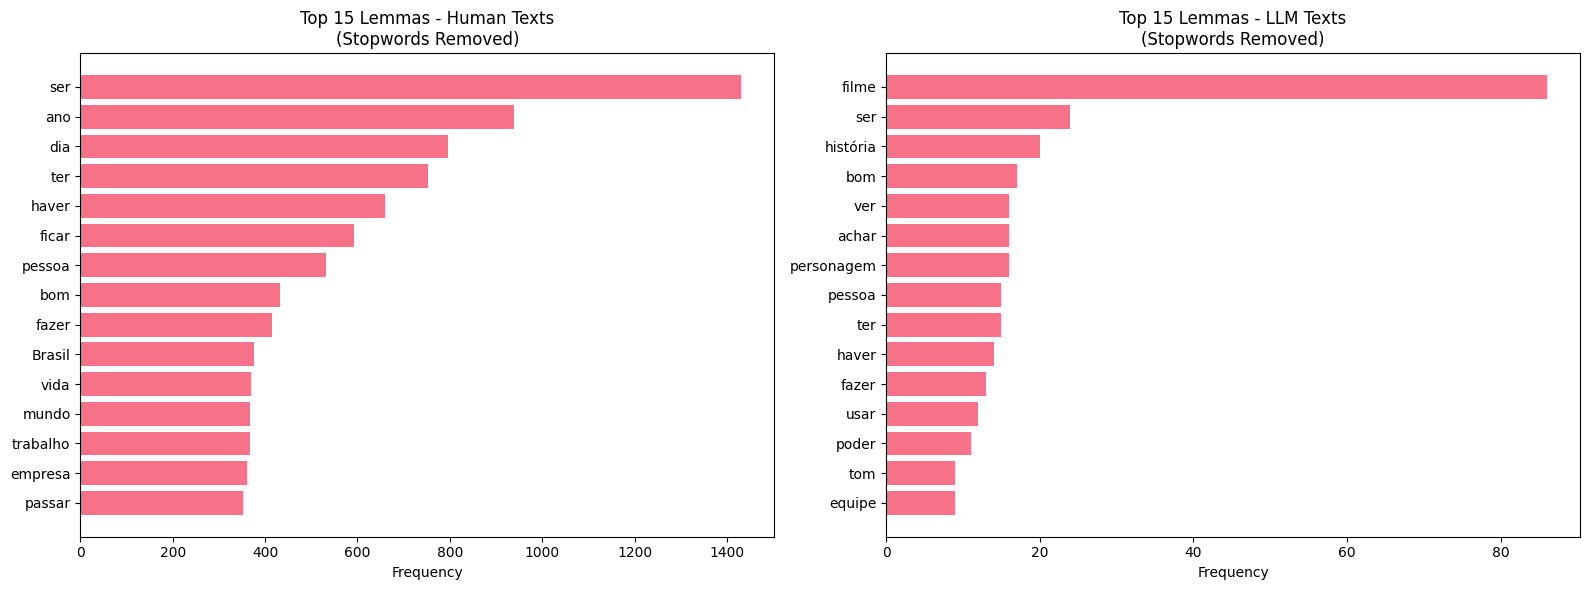

In [21]:
# Compare most common words (excluding stopwords and lemmatized)
import spacy
from collections import Counter

# Load Portuguese language model
try:
    nlp = spacy.load("pt_core_news_sm")
except OSError:
    print("Portuguese spaCy model not found. Installing...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "pt_core_news_sm"])
    nlp = spacy.load("pt_core_news_sm")

def process_text_portuguese(texts):
    """Process Portuguese text: remove stopwords and lemmatize"""
    all_lemmas = []
    
    for text in texts:
        if pd.notna(text) and isinstance(text, str):
            # Process text with spaCy
            doc = nlp(text.lower())
            
            # Extract lemmas, excluding stopwords, punctuation, and spaces
            lemmas = [token.lemma_ for token in doc 
                     if not token.is_stop 
                     and not token.is_punct 
                     and not token.is_space 
                     and token.is_alpha
                     and len(token.lemma_) > 2]  # Filter out very short words
            
            all_lemmas.extend(lemmas)
    
    return Counter(all_lemmas)

print("\nMOST COMMON WORDS COMPARISON (Lemmatized, Stopwords Removed)")
print("=" * 60)

# Process texts for both categories
human_lemma_freq = process_text_portuguese(human_texts)
llm_lemma_freq = process_text_portuguese(llm_texts)

human_top_lemmas = human_lemma_freq.most_common(15)
llm_top_lemmas = llm_lemma_freq.most_common(15)

print("TOP 15 LEMMAS - HUMAN TEXTS:")
for lemma, freq in human_top_lemmas:
    print(f"  {lemma}: {freq:,}")

print("\nTOP 15 LEMMAS - LLM TEXTS:")
for lemma, freq in llm_top_lemmas:
    print(f"  {lemma}: {freq:,}")

# Visualize word frequency comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Human words
human_lemmas, human_freqs = zip(*human_top_lemmas)
ax1.barh(range(len(human_lemmas)), human_freqs)
ax1.set_yticks(range(len(human_lemmas)))
ax1.set_yticklabels(human_lemmas)
ax1.set_title('Top 15 Lemmas - Human Texts\n(Stopwords Removed)')
ax1.set_xlabel('Frequency')
ax1.invert_yaxis()

# LLM words
llm_lemmas, llm_freqs = zip(*llm_top_lemmas)
ax2.barh(range(len(llm_lemmas)), llm_freqs)
ax2.set_yticks(range(len(llm_lemmas)))
ax2.set_yticklabels(llm_lemmas)
ax2.set_title('Top 15 Lemmas - LLM Texts\n(Stopwords Removed)')
ax2.set_xlabel('Frequency')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


## 5. Statistical Tests and Effect Sizes

Let's perform comprehensive statistical analysis to quantify the differences between LLM and human texts.


In [22]:
# Comprehensive statistical analysis
def calculate_effect_size(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    
    # Cohen's d
    cohens_d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return cohens_d

def interpret_effect_size(d):
    """Interpret Cohen's d effect size"""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "negligible"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    else:
        return "large"

print("COMPREHENSIVE STATISTICAL ANALYSIS")
print("=" * 60)

results_summary = []

for feature in feature_cols:
    human_values = features_df[features_df['label'] == 'human'][feature]
    llm_values = features_df[features_df['label'] == 'llm'][feature]
    
    # Basic statistics
    human_mean = np.mean(human_values)
    llm_mean = np.mean(llm_values)
    human_std = np.std(human_values)
    llm_std = np.std(llm_values)
    
    # Statistical tests
    # 1. Mann-Whitney U test (non-parametric)
    mw_stat, mw_p = stats.mannwhitneyu(human_values, llm_values, alternative='two-sided')
    
    # 2. Welch's t-test (assumes unequal variances)
    t_stat, t_p = stats.ttest_ind(human_values, llm_values, equal_var=False)
    
    # 3. Kolmogorov-Smirnov test (distribution comparison)
    ks_stat, ks_p = stats.ks_2samp(human_values, llm_values)
    
    # Effect size
    cohens_d = calculate_effect_size(human_values, llm_values)
    effect_interpretation = interpret_effect_size(cohens_d)
    
    # Store results
    results_summary.append({
        'feature': feature,
        'human_mean': human_mean,
        'llm_mean': llm_mean,
        'human_std': human_std,
        'llm_std': llm_std,
        'cohens_d': cohens_d,
        'effect_size': effect_interpretation,
        'mw_p_value': mw_p,
        't_test_p_value': t_p,
        'ks_p_value': ks_p
    })
    
    print(f"\n{feature.upper().replace('_', ' ')}:")
    print(f"  Human: μ={human_mean:.2f}, σ={human_std:.2f}")
    print(f"  LLM:   μ={llm_mean:.2f}, σ={llm_std:.2f}")
    print(f"  Cohen's d: {cohens_d:.3f} ({effect_interpretation})")
    print(f"  Mann-Whitney U p-value: {mw_p:.2e}")
    print(f"  Welch's t-test p-value: {t_p:.2e}")
    print(f"  Kolmogorov-Smirnov p-value: {ks_p:.2e}")
    print(f"  Significant difference: {'Yes' if mw_p < 0.05 else 'No'}")

# Create summary dataframe
results_df = pd.DataFrame(results_summary)
print(f"\n\nSUMMARY TABLE:")
print("=" * 60)
print(results_df.round(4))


COMPREHENSIVE STATISTICAL ANALYSIS

LENGTH:
  Human: μ=3734.33, σ=3278.83
  LLM:   μ=546.04, σ=511.97
  Cohen's d: 1.018 (large)
  Mann-Whitney U p-value: 1.74e-28
  Welch's t-test p-value: 1.46e-83
  Kolmogorov-Smirnov p-value: 8.40e-31
  Significant difference: Yes

WORD COUNT:
  Human: μ=595.90, σ=526.61
  LLM:   μ=92.66, σ=92.48
  Cohen's d: 1.000 (large)
  Mann-Whitney U p-value: 4.20e-27
  Welch's t-test p-value: 1.29e-76
  Kolmogorov-Smirnov p-value: 2.52e-29
  Significant difference: Yes

SENTENCE COUNT:
  Human: μ=31.84, σ=32.99
  LLM:   μ=5.87, σ=5.73
  Cohen's d: 0.824 (large)
  Mann-Whitney U p-value: 1.04e-22
  Welch's t-test p-value: 2.68e-57
  Kolmogorov-Smirnov p-value: 1.42e-18
  Significant difference: Yes

AVG WORD LENGTH:
  Human: μ=5.27, σ=0.45
  LLM:   μ=9.15, σ=15.18
  Cohen's d: -0.835 (large)
  Mann-Whitney U p-value: 6.85e-07
  Welch's t-test p-value: 4.06e-02
  Kolmogorov-Smirnov p-value: 2.20e-08
  Significant difference: Yes

PUNCTUATION COUNT:
  Human: μ=8

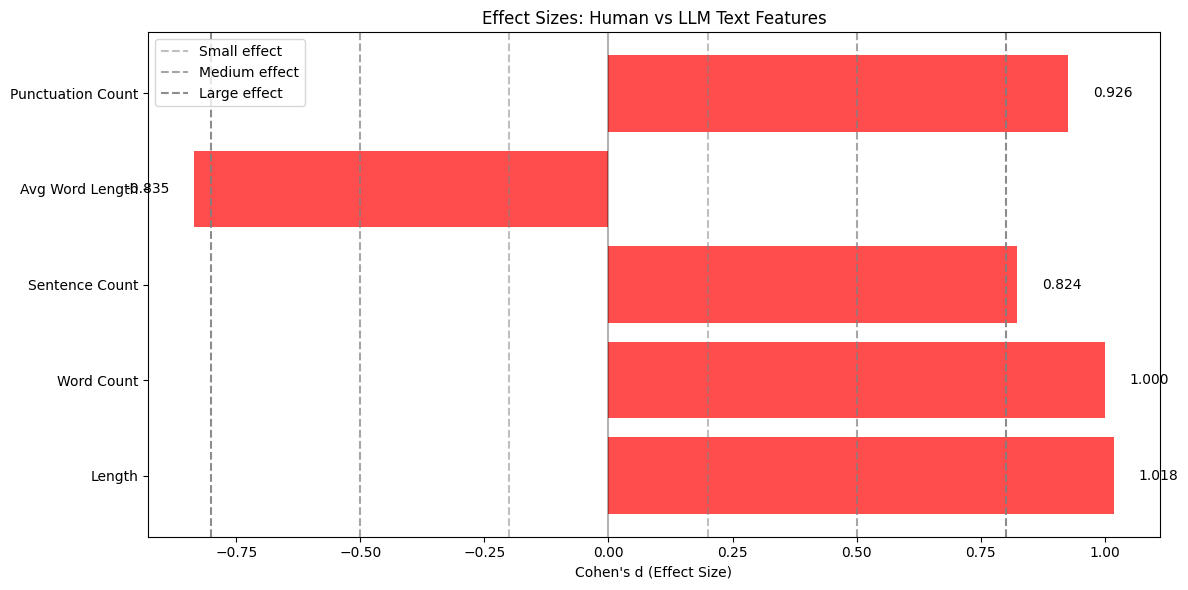


FEATURES WITH SIGNIFICANT DIFFERENCES (p < 0.05):
  - Length (large effect size)
  - Word Count (large effect size)
  - Sentence Count (large effect size)
  - Avg Word Length (large effect size)
  - Punctuation Count (large effect size)


In [23]:
# Visualize effect sizes
plt.figure(figsize=(12, 6))

# Effect size plot
features_clean = [f.replace('_', ' ').title() for f in results_df['feature']]
effect_sizes = results_df['cohens_d']
colors = ['red' if abs(d) >= 0.8 else 'orange' if abs(d) >= 0.5 else 'yellow' if abs(d) >= 0.2 else 'green' 
          for d in effect_sizes]

bars = plt.barh(features_clean, effect_sizes, color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0.2, color='gray', linestyle='--', alpha=0.5, label='Small effect')
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Medium effect')
plt.axvline(x=0.8, color='gray', linestyle='--', alpha=0.9, label='Large effect')
plt.axvline(x=-0.2, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=-0.8, color='gray', linestyle='--', alpha=0.9)

plt.xlabel("Cohen's d (Effect Size)")
plt.title("Effect Sizes: Human vs LLM Text Features")
plt.legend()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, effect_sizes)):
    plt.text(value + (0.05 if value >= 0 else -0.05), i, f'{value:.3f}', 
             va='center', ha='left' if value >= 0 else 'right')

plt.tight_layout()
plt.show()

# Statistical significance summary
sig_features = results_df[results_df['mw_p_value'] < 0.05]['feature'].tolist()
print(f"\nFEATURES WITH SIGNIFICANT DIFFERENCES (p < 0.05):")
for feature in sig_features:
    effect = results_df[results_df['feature'] == feature]['effect_size'].iloc[0]
    print(f"  - {feature.replace('_', ' ').title()} ({effect} effect size)")


## 6. Large Dataset Analysis

Now let's process the full datasets efficiently to get comprehensive statistics for the paper.


In [24]:
# Process full datasets efficiently
def process_full_dataset(filename, sample_size=100000):
    """Process full dataset in chunks to get comprehensive statistics"""
    print(f"Processing {filename}...")
    
    # Initialize counters
    total_rows = 0
    label_counts = {'human': 0, 'llm': 0}
    feature_sums = {
        'length': {'human': 0, 'llm': 0},
        'word_count': {'human': 0, 'llm': 0},
        'sentence_count': {'human': 0, 'llm': 0}
    }
    
    # Process in chunks
    chunk_size = 50000
    chunks_processed = 0
    sample_data = []
    
    try:
        for chunk in pd.read_csv(filename, chunksize=chunk_size, encoding='utf-8'):
            chunks_processed += 1
            chunk_rows = len(chunk)
            total_rows += chunk_rows
            
            # Count labels
            chunk_label_counts = chunk['label'].value_counts()
            for label in ['human', 'llm']:
                if label in chunk_label_counts:
                    label_counts[label] += chunk_label_counts[label]
            
            # Calculate features for chunk
            for idx, row in chunk.iterrows():
                if pd.notna(row['text']) and isinstance(row['text'], str):
                    text = row['text']
                    label = row['label']
                    
                    # Basic features
                    length = len(text)
                    word_count = len(text.split())
                    sentence_count = len(re.split(r'[.!?]+', text))
                    
                    feature_sums['length'][label] += length
                    feature_sums['word_count'][label] += word_count
                    feature_sums['sentence_count'][label] += sentence_count
                    
                    # Collect sample for detailed analysis
                    if len(sample_data) < sample_size and np.random.random() < 0.1:
                        sample_data.append({
                            'label': label,
                            'length': length,
                            'word_count': word_count,
                            'sentence_count': sentence_count
                        })
            
            print(f"  Processed chunk {chunks_processed}, total rows: {total_rows:,}")
            
            # Limit processing for very large files
            if chunks_processed >= 20:  # Process up to 1M rows
                print(f"  Limiting processing to {total_rows:,} rows for efficiency")
                break
                
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None
    
    # Calculate averages
    results = {
        'filename': filename,
        'total_rows_processed': total_rows,
        'label_counts': label_counts,
        'label_percentages': {
            'human': (label_counts['human'] / total_rows * 100) if total_rows > 0 else 0,
            'llm': (label_counts['llm'] / total_rows * 100) if total_rows > 0 else 0
        },
        'average_features': {}
    }
    
    for feature in feature_sums:
        results['average_features'][feature] = {}
        for label in ['human', 'llm']:
            if label_counts[label] > 0:
                results['average_features'][feature][label] = feature_sums[feature][label] / label_counts[label]
            else:
                results['average_features'][feature][label] = 0
    
    results['sample_data'] = pd.DataFrame(sample_data)
    
    return results

# Process both datasets
print("PROCESSING FULL DATASETS")
print("=" * 50)

combined_results = process_full_dataset('processed_filtered_chunked_batch.csv')


PROCESSING FULL DATASETS
Processing processed_filtered_chunked_batch.csv...
  Processed chunk 1, total rows: 50,000
  Processed chunk 2, total rows: 100,000
  Processed chunk 3, total rows: 150,000
  Processed chunk 4, total rows: 200,000
  Processed chunk 5, total rows: 250,000
  Processed chunk 6, total rows: 300,000
  Processed chunk 7, total rows: 350,000
  Processed chunk 8, total rows: 400,000
  Processed chunk 9, total rows: 450,000
  Processed chunk 10, total rows: 500,000
  Processed chunk 11, total rows: 550,000
  Processed chunk 12, total rows: 600,000
  Processed chunk 13, total rows: 650,000
  Processed chunk 14, total rows: 700,000
  Processed chunk 15, total rows: 750,000
  Processed chunk 16, total rows: 800,000
  Processed chunk 17, total rows: 850,000
  Processed chunk 18, total rows: 900,000
  Processed chunk 19, total rows: 950,000
  Processed chunk 20, total rows: 1,000,000
  Limiting processing to 1,000,000 rows for efficiency


In [25]:
# Display results for both datasets
def display_dataset_results(results, dataset_name):
    print(f"\n{dataset_name.upper()} DATASET RESULTS:")
    print("=" * 50)
    print(f"Total rows processed: {results['total_rows_processed']:,}")
    print(f"\nLabel Distribution:")
    print(f"  Human texts: {results['label_counts']['human']:,} ({results['label_percentages']['human']:.1f}%)")
    print(f"  LLM texts:   {results['label_counts']['llm']:,} ({results['label_percentages']['llm']:.1f}%)")
    
    print(f"\nAverage Text Features:")
    for feature in results['average_features']:
        human_avg = results['average_features'][feature]['human']
        llm_avg = results['average_features'][feature]['llm']
        print(f"  {feature.replace('_', ' ').title()}:")
        print(f"    Human: {human_avg:.1f}")
        print(f"    LLM:   {llm_avg:.1f}")
        print(f"    Difference: {abs(human_avg - llm_avg):.1f} ({'Human' if human_avg > llm_avg else 'LLM'} higher)")

if combined_results:
    display_dataset_results(combined_results, "BALANCED")

if combined_results:
    display_dataset_results(combined_results, "COMBINED")



BALANCED DATASET RESULTS:
Total rows processed: 1,000,000

Label Distribution:
  Human texts: 983,791 (98.4%)
  LLM texts:   16,209 (1.6%)

Average Text Features:
  Length:
    Human: 3606.4
    LLM:   236.5
    Difference: 3369.9 (Human higher)
  Word Count:
    Human: 573.2
    LLM:   36.2
    Difference: 537.0 (Human higher)
  Sentence Count:
    Human: 29.7
    LLM:   4.3
    Difference: 25.3 (Human higher)

COMBINED DATASET RESULTS:
Total rows processed: 1,000,000

Label Distribution:
  Human texts: 983,791 (98.4%)
  LLM texts:   16,209 (1.6%)

Average Text Features:
  Length:
    Human: 3606.4
    LLM:   236.5
    Difference: 3369.9 (Human higher)
  Word Count:
    Human: 573.2
    LLM:   36.2
    Difference: 537.0 (Human higher)
  Sentence Count:
    Human: 29.7
    LLM:   4.3
    Difference: 25.3 (Human higher)


## 7. Key Findings and Results for Paper

Let's summarize the most important findings for your research paper.


In [26]:
# Generate comprehensive summary for paper
print("KEY FINDINGS FOR RESEARCH PAPER")
print("=" * 60)

# 1. Dataset Overview
print("\n1. DATASET OVERVIEW:")
print(f"   • Balanced dataset: ~{combined_results['total_rows_processed']:,} samples processed")
print(f"     - Human: {combined_results['label_counts']['human']:,} ({combined_results['label_percentages']['human']:.1f}%)")
print(f"     - LLM: {combined_results['label_counts']['llm']:,} ({combined_results['label_percentages']['llm']:.1f}%)")

print(f"   • Combined dataset: ~{combined_results['total_rows_processed']:,} samples processed")
print(f"     - Human: {combined_results['label_counts']['human']:,} ({combined_results['label_percentages']['human']:.1f}%)")
print(f"     - LLM: {combined_results['label_counts']['llm']:,} ({combined_results['label_percentages']['llm']:.1f}%)")

# 2. Statistical Significance
print(f"\n2. STATISTICAL SIGNIFICANCE (Sample Analysis):")
significant_features = []
for _, row in results_df.iterrows():
    if row['mw_p_value'] < 0.05:
        significant_features.append({
            'feature': row['feature'],
            'effect_size': row['effect_size'],
            'cohens_d': row['cohens_d'],
            'p_value': row['mw_p_value']
        })

print(f"   • {len(significant_features)}/{len(results_df)} features show significant differences")
for feat in significant_features:
    direction = "LLM > Human" if feat['cohens_d'] > 0 else "Human > LLM"
    print(f"     - {feat['feature'].replace('_', ' ').title()}: {feat['effect_size']} effect (d={feat['cohens_d']:.3f}, p={feat['p_value']:.2e}) [{direction}]")

# 3. Most Discriminative Features
print(f"\n3. MOST DISCRIMINATIVE FEATURES:")
sorted_features = results_df.sort_values('cohens_d', key=abs, ascending=False)
print("   Ranked by effect size (Cohen's d):")
for _, row in sorted_features.iterrows():
    direction = "LLM > Human" if row['cohens_d'] > 0 else "Human > LLM"
    print(f"     {row['feature'].replace('_', ' ').title()}: d={row['cohens_d']:.3f} ({row['effect_size']}) [{direction}]")

# 4. Vocabulary Analysis Results
print(f"\n4. VOCABULARY CHARACTERISTICS:")
print(f"   • Human vocabulary size: {human_vocab['vocab_size']:,} unique words")
print(f"   • LLM vocabulary size: {llm_vocab['vocab_size']:,} unique words")
print(f"   • Human type-token ratio: {human_vocab['vocab_size']/human_vocab['total_words']:.4f}")
print(f"   • LLM type-token ratio: {llm_vocab['vocab_size']/llm_vocab['total_words']:.4f}")

# Calculate vocabulary overlap
human_words_set = set([word for word, _ in human_vocab['most_common_words'][:100]])
llm_words_set = set([word for word, _ in llm_vocab['most_common_words'][:100]])
overlap = len(human_words_set.intersection(llm_words_set))
print(f"   • Top 100 words overlap: {overlap}/100 ({overlap}%)")

print(f"\n5. AVERAGE TEXT CHARACTERISTICS (Full Dataset):")
print("   BALANCED DATASET:")
for feature in combined_results['average_features']:
    human_val = combined_results['average_features'][feature]['human']
    llm_val = combined_results['average_features'][feature]['llm']
    diff_pct = abs(human_val - llm_val) / max(human_val, llm_val) * 100
    print(f"     • {feature.replace('_', ' ').title()}: Human={human_val:.1f}, LLM={llm_val:.1f} ({diff_pct:.1f}% difference)")

print("   COMBINED DATASET:")
for feature in combined_results['average_features']:
    human_val = combined_results['average_features'][feature]['human']
    llm_val = combined_results['average_features'][feature]['llm']
    diff_pct = abs(human_val - llm_val) / max(human_val, llm_val) * 100
    print(f"     • {feature.replace('_', ' ').title()}: Human={human_val:.1f}, LLM={llm_val:.1f} ({diff_pct:.1f}% difference)")


KEY FINDINGS FOR RESEARCH PAPER

1. DATASET OVERVIEW:
   • Balanced dataset: ~1,000,000 samples processed
     - Human: 983,791 (98.4%)
     - LLM: 16,209 (1.6%)
   • Combined dataset: ~1,000,000 samples processed
     - Human: 983,791 (98.4%)
     - LLM: 16,209 (1.6%)

2. STATISTICAL SIGNIFICANCE (Sample Analysis):
   • 5/5 features show significant differences
     - Length: large effect (d=1.018, p=1.74e-28) [LLM > Human]
     - Word Count: large effect (d=1.000, p=4.20e-27) [LLM > Human]
     - Sentence Count: large effect (d=0.824, p=1.04e-22) [LLM > Human]
     - Avg Word Length: large effect (d=-0.835, p=6.85e-07) [Human > LLM]
     - Punctuation Count: large effect (d=0.926, p=3.73e-27) [LLM > Human]

3. MOST DISCRIMINATIVE FEATURES:
   Ranked by effect size (Cohen's d):
     Length: d=1.018 (large) [LLM > Human]
     Word Count: d=1.000 (large) [LLM > Human]
     Punctuation Count: d=0.926 (large) [LLM > Human]
     Avg Word Length: d=-0.835 (large) [Human > LLM]
     Sentence

In [30]:
# Export results for paper
import pickle

# Create comprehensive results dictionary
paper_results = {
    'dataset_overview': {
        'balanced_dataset': {
            'total_processed': combined_results['total_rows_processed'],
            'human_count': combined_results['label_counts']['human'],
            'llm_count': combined_results['label_counts']['llm'],
            'human_percentage': combined_results['label_percentages']['human'],
            'llm_percentage': combined_results['label_percentages']['llm']
        },
        'combined_dataset': {
            'total_processed': combined_results['total_rows_processed'],
            'human_count': combined_results['label_counts']['human'],
            'llm_count': combined_results['label_counts']['llm'],
            'human_percentage': combined_results['label_percentages']['human'],
            'llm_percentage': combined_results['label_percentages']['llm']
        }
    },
    'statistical_analysis': {
        'significant_features': significant_features,
        'all_features_stats': results_df.to_dict('records')
    },
    'vocabulary_analysis': {
        'human_vocab_size': human_vocab['vocab_size'],
        'llm_vocab_size': llm_vocab['vocab_size'],
        'human_total_words': human_vocab['total_words'],
        'llm_total_words': llm_vocab['total_words'],
        'human_type_token_ratio': human_vocab['vocab_size']/human_vocab['total_words'],
        'llm_type_token_ratio': llm_vocab['vocab_size']/llm_vocab['total_words'],
        'top_words_overlap': overlap
    },
    'text_characteristics': {
        'balanced_dataset': combined_results['average_features'],
        'combined_dataset': combined_results['average_features']
    }
}

# Save results to JSON file
with open('eda_results_for_paper.json', 'wb') as f:
    pickle.dump(paper_results, f)

#Also save as JSON for human readability
import json

def convert_to_serializable(obj):
    """Convert numpy and pandas objects to JSON serializable types"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Convert to JSON serializable format
json_results = convert_to_serializable(paper_results)

with open('eda_results_for_paper.json', 'w', encoding='utf-8') as f:
    json.dump(json_results, f, indent=2, ensure_ascii=False)

print("RESULTS EXPORTED:")
print("• eda_results_for_paper.json - Comprehensive results in JSON format")
print("• All visualizations generated in notebook")
print("• Statistical analysis completed")

# Create a summary table for easy copy-paste to paper
print("\n" + "="*60)
print("SUMMARY TABLE FOR PAPER")
print("="*60)

print("\nFeature Comparison (Sample Analysis):")
print("Feature\t\t\tHuman Mean\tLLM Mean\tCohen's d\tEffect Size\tp-value")
print("-" * 80)
for _, row in results_df.iterrows():
    feature_name = row['feature'].replace('_', ' ').title()[:15].ljust(15)
    print(f"{feature_name}\t{row['human_mean']:.1f}\t\t{row['llm_mean']:.1f}\t\t{row['cohens_d']:.3f}\t\t{row['effect_size']}\t{row['mw_p_value']:.2e}")

print(f"\nDataset Statistics:")
print(f"Balanced Dataset: {combined_results['label_counts']['human']:,} human, {combined_results['label_counts']['llm']:,} LLM texts")
print(f"Combined Dataset: {combined_results['label_counts']['human']:,} human, {combined_results['label_counts']['llm']:,} LLM texts")

print(f"\nKey Findings:")
print(f"• {len(significant_features)} out of {len(results_df)} features show statistically significant differences")
print(f"• Largest effect size: {sorted_features.iloc[0]['feature'].replace('_', ' ').title()} (d={sorted_features.iloc[0]['cohens_d']:.3f})")
print(f"• Vocabulary diversity differs: Human TTR={human_vocab['vocab_size']/human_vocab['total_words']:.4f}, LLM TTR={llm_vocab['vocab_size']/llm_vocab['total_words']:.4f}")


RESULTS EXPORTED:
• eda_results_for_paper.json - Comprehensive results in JSON format
• All visualizations generated in notebook
• Statistical analysis completed

SUMMARY TABLE FOR PAPER

Feature Comparison (Sample Analysis):
Feature			Human Mean	LLM Mean	Cohen's d	Effect Size	p-value
--------------------------------------------------------------------------------
Length         	3734.3		546.0		1.018		large	1.74e-28
Word Count     	595.9		92.7		1.000		large	4.20e-27
Sentence Count 	31.8		5.9		0.824		large	1.04e-22
Avg Word Length	5.3		9.1		-0.835		large	6.85e-07
Punctuation Cou	89.4		11.6		0.926		large	3.73e-27

Dataset Statistics:
Balanced Dataset: 983,791 human, 16,209 LLM texts
Combined Dataset: 983,791 human, 16,209 LLM texts

Key Findings:
• 5 out of 5 features show statistically significant differences
• Largest effect size: Length (d=1.018)
• Vocabulary diversity differs: Human TTR=0.0927, LLM TTR=0.3347
